In [37]:
import pandas as pd
import json
import os
import context_window_helper as cwh
import matplotlib.pyplot as plt
import numpy as np


In [38]:
filepath = r"C:\Users\Gert\repos\CS2_cheat_detection\DataConversionPipeline\test_data\0"

# Loading csv tick data as a pd.DataFrame
match_ticks = pd.read_parquet(path=filepath+".parquet")

# Loading json event data a list of tuples (str, pd.Dataframe)
def json_2_eventlist(filepath:str) -> list:
    with open(filepath, "r") as f:
        json_data = json.load(f)

    data = []

    for key, value in json_data.items():
        if isinstance(value, list):
            df = pd.DataFrame(value)
            data.append((key, df))

    return data

match_events = json_2_eventlist(filepath=filepath+".json")

# print(match_events)

In [39]:
ticks_before_kill = 896
ticks_after_kill = 128
context_window_size = ticks_before_kill + ticks_after_kill

context_window_vals = ["attacker_X", "attacker_Y", "attacker_Z", "attacker_vel_X", "attacker_vel_Y", "attacker_vel_Z", "attacker_pitch", "attacker_yaw", "attacker_pitch_delta", 
                       "attacker_yaw_delta", "attacker_pitch_head_delta", "attacker_yaw_head_delta", "attacker_flashed", "attacker_shot", "attacker_kill", "is_kill_through_smoke", 
                       "is_kill_wallbang", "attacker_midair", "attacker_weapon_knife", "attacker_weapon_auto_rifle", "attacker_weapon_semi_rifle", "attacker_weapon_pistol",
                       "attacker_weapon_grenade", "attacker_weapon_smg", "attacker_weapon_shotgun",
                       "victim_X", "victim_Y", "victim_Z", "victim_health", "victim_noise", "map_dust2", "map_mirage", "map_inferno", "map_train",
                       "map_nuke", "map_ancient", "map_vertigo", "map_anubis", "map_office", "map_overpass", "map_basalt", "map_edin", "map_italy", "map_thera", "map_mills"]

In [45]:
# # FAFO cell

# # idx = match_ticks[(match_ticks["flash_duration"] > 0)&(match_ticks["name"] == "Player_3")].index
# # vals = match_ticks.iloc[idx][["flash_duration", "tick"]]

# # for i in match_ticks.columns:
#     # print(i)

# # for i in match_events:
#     # print(i[0])

# # match_events[36][1]["attackerinair"]
# # plt.plot(match_events[36][1]["attackerinair"])

match_ticks[match_ticks["name"] == "Player_3"]["active_weapon"]
# match_ticks[match_ticks["name"] == "Player_3"]["inventory_as_ids"]
# match_ticks[match_ticks["name"] == "Player_3"]["inventory"]

mask = match_ticks.head(100).isin([14893564.0])
row_indices = mask.any(axis=1)
matching_rows = match_ticks.head(100)[row_indices]
matching_rows

,inventory,usercmd_input_history,inventory_as_ids,approximate_spotted_by,aim_punch_angle_vel,aim_punch_angle,active_weapon_ammo,item_def_idx,weapon_quality,entity_lvl,...,usercmd_forward_move,usercmd_consumed_server_angle_changes,is_alive,velocity_Z,active_weapon_name,usercmd_mouse_dx,game_time,tick,steamid,name
9,"[knife, USP-S]",[],"[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,NaN,NaN,True,NaN,knife,NaN,51.187500,1,Player_3,Player_3
19,"[knife, USP-S]","[{'player_tick_count': 3276, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,NaN,knife,0.0,51.203125,2,Player_3,Player_3
29,"[knife, USP-S]","[{'player_tick_count': 3276, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.218750,3,Player_3,Player_3
39,"[knife, USP-S]","[{'player_tick_count': 3277, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.234375,4,Player_3,Player_3
49,"[knife, USP-S]","[{'player_tick_count': 3279, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.250000,5,Player_3,Player_3
59,"[knife, USP-S]","[{'player_tick_count': 3280, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.265625,6,Player_3,Player_3
69,"[knife, USP-S]","[{'player_tick_count': 3281, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.281250,7,Player_3,Player_3
79,"[knife, USP-S]","[{'player_tick_count': 3281, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.296875,8,Player_3,Player_3
89,"[knife, USP-S]","[{'player_tick_count': 3283, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.312500,9,Player_3,Player_3
99,"[knife, USP-S]","[{'player_tick_count': 3283, 'player_tick_frac...","[42, 61]",[],"[-38.58543395996094, 0.0, 0.0]","[-0.329881489276886, 0.0, 0.0]",0.0,42.0,0.0,1.0,...,0.0,0.0,True,0.0,knife,0.0,51.328125,10,Player_3,Player_3


In [5]:
MDP = cwh.MatchDataProcessor(match_ticks, match_events, context_window_size)

In [6]:
# player = "Player_3" # For testug purposes, a cheater is specifically chosen
player = "Player_3"
player_death_idx = -1
weapon_fire_idx = -1

for idx, event in enumerate(match_events):
    if event[0] == "player_death":
        player_death_idx = idx
    if event[0] == "weapon_fire":
        weapon_fire_idx = idx
if player_death_idx == -1 or weapon_fire_idx == -1:
    raise Exception("not all events were found")

player_deaths = MDP.get_player_kills(player, player_death_idx)
start_ticks, end_ticks = MDP.get_context_window_ticks(ticks_before_kill, ticks_after_kill, player, player_death_idx)

context_window = pd.DataFrame(columns=context_window_vals)

for i in range(0,len(start_ticks)):

    # Check length of the context window and no ticks missing
    ticks = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "tick")
    if len(ticks) != context_window_size:
        gap = context_window_size - len(ticks)
        all_ticks = MDP.get_all_values_for_player(player, "tick")
        
        idx = all_ticks.index(start_ticks[i])
        end_ticks[i] = all_ticks[idx + 1024]
        

    context_window["attacker_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "X")
    context_window["attacker_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Y")
    context_window["attacker_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "Z")

    context_window["attacker_vel_X"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_X")
    context_window["attacker_vel_Y"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Y")
    context_window["attacker_vel_Z"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "velocity_Z")

    context_window["attacker_pitch"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "pitch")
    context_window["attacker_yaw"] = MDP.get_tick_values(start_ticks[i], end_ticks[i], player, "yaw")
    context_window["attacker_pitch_delta"] = MDP.get_pitch_yaw_deltas("pitch", start_ticks[i], end_ticks[i], player)
    context_window["attacker_yaw_delta"] = MDP.get_pitch_yaw_deltas("yaw", start_ticks[i], end_ticks[i], player)

    context_window["attacker_pitch_head_delta"], context_window["attacker_yaw_head_delta"] = MDP.get_pitch_yaw_head_deltas(start_ticks[i], end_ticks[i], context_window_size, player, player_deaths.iloc[i]["user_name"])

    context_window["attacker_flashed"] = MDP.get_is_player_flashed(start_ticks[i], end_ticks[i], player)
    context_window["attacker_shot"] = MDP.get_attacker_shots(start_ticks[i], end_ticks[i], player, weapon_fire_idx)
    context_window["attacker_kill"], context_window["is_kill_through_smoke"], context_window["is_kill_wallbang"], context_window["attacker_midair"] = MDP.get_attacker_kill_data(start_ticks[i], end_ticks[i], player, player_death_idx)
    

    break # Remove later, currently used for testing


# context_window
# player_deaths

[False]


1.0


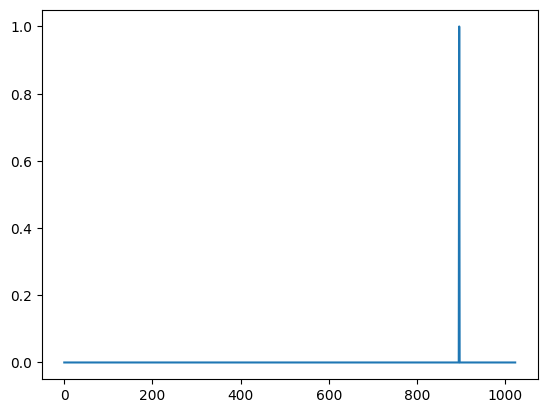

In [ ]:
# Testing to see if the delta to head values are correct. They seem to be, maybe should
# do a custom test scenario


# print(player_deaths.iloc[7]["weapon"])

# plt.plot(context_window["attacker_pitch_head_delta"])
# plt.plot(context_window["attacker_yaw_head_delta"])
# plt.axvline(x=896)
# plt.show()

# plt.plot(context_window["attacker_kill"])
# plt.show()

plt.plot(context_window["attacker_midair"])
plt.show()